In [1]:
# Load Dataset

import torch
dataset = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined_3.pt",weights_only=False)

In [ ]:
## Process dataset for training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData

def build_laststep_features(data, dtype=torch.float32):
    ## Collapse to peak load timestep
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    #pos   = data['nodes'].pos.to(dtype) #no need to include
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes → u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].pos, data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int
    del data['elements'].s_ts, data['elements'].d_ts, data['elements'].material, data['nodes'].f_ts
    #print(data.keys)

    return data

class HeteroStandardScaler:
    def __init__(self):
        self.node_stats = {}
        self.edge_stats = {}

    def fit(self, dataset):
        node_x = torch.cat([d['nodes'].x[:,3:].float() for d in dataset],dim=0)
        node_f = torch.cat([d['nodes'].y_fint.float() for d in dataset],dim=0)
        node_u = torch.cat([d['nodes'].y_u.float() for d in dataset],dim=0)
        elem_s = torch.cat([d['elements'].y_s.float() for d in dataset],dim=0)
        edge_acc = {}
        # compute mean/std
        for data in dataset:

            for etype in data.edge_types:
                if "edge_attr" in data[etype]:
                    e = data[etype].edge_attr.float()
                    self.edge_stats[etype] = {
                        "mean": e.mean(dim=0, keepdim=True),
                        "std":  e.std(dim=0, keepdim=True) + 1e-8}
        
        self.node_stats['nodes_x'] = {
            "mean": node_x.mean(dim=0, keepdim=True),
            "std":  node_x.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_f'] = {
            "mean": node_f.mean(dim=0, keepdim=True),
            "std":  node_f.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_u'] = {
            "mean": node_u.mean(dim=0, keepdim=True),
            "std":  node_u.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['elem_s'] = {
            "mean": elem_s.mean(dim=0, keepdim=True),
            "std":  elem_s.std(dim=0, keepdim=True) + 1e-8}
        for etype, mats in edge_acc.items():
            E = torch.cat(mats, dim=0)
            self.edge_stats[etype] = {
                "mean": E.mean(dim=0, keepdim=True),
                "std":  E.std(dim=0, keepdim=True) + 1e-8}


    def transform(self, data: HeteroData):
        # apply normalization
        x = data['nodes'].x[:,3:].float()
        m_x = self.node_stats['nodes_x']["mean"]
        s_x = self.node_stats['nodes_x']["std"]
        data['nodes'].x[:,3:] = (x - m_x) / s_x
        y_f = data['nodes'].y_fint.float()
        m_f = self.node_stats['nodes_f']["mean"]
        s_f = self.node_stats['nodes_f']["std"]
        data['nodes'].y_fint = (y_f - m_f) / s_f
        y_u = data['nodes'].y_u.float()
        m_u = self.node_stats['nodes_u']["mean"]
        s_u = self.node_stats['nodes_u']["std"]
        data['nodes'].y_u = (y_u - m_u) / s_u
        y_s = data['elements'].y_s.float()
        m_s = self.node_stats['elem_s']["mean"]
        s_s = self.node_stats['elem_s']["std"]
        data['elements'].y_s = (y_s - m_s) / s_s

        # edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                e = data[etype].edge_attr.float()
                m = self.edge_stats[etype]["mean"]
                s = self.edge_stats[etype]["std"]
                data[etype].edge_attr = (e - m) / s

        return data
    
    def inverse_transform(self, data: HeteroData, fields=("nodes_x","nodes_f","nodes_u","elem_s")):
        # Nodes
        if "nodes_x" in fields:
            m, s = self.node_stats["nodes_x"]["mean"], self.node_stats["nodes_x"]["std"]
            data["nodes"].x[:, 3:] = data["nodes"].x[:, 3:] * s + m
        if "nodes_f" in fields:
            m, s = self.node_stats["nodes_f"]["mean"], self.node_stats["nodes_f"]["std"]
            data["nodes"].y_fint = data["nodes"].y_fint * s + m
        if "nodes_u" in fields:
            m, s = self.node_stats["nodes_u"]["mean"], self.node_stats["nodes_u"]["std"]
            data["nodes"].y_u = data["nodes"].y_u * s + m
        if "elem_s" in fields:
            m, s = self.node_stats["elem_s"]["mean"], self.node_stats["elem_s"]["std"]
            data["elements"].y_s = data["elements"].y_s * s + m

        # Edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                m, s = self.edge_stats[etype]["mean"], self.edge_stats[etype]["std"]
                data[etype].edge_attr = data[etype].edge_attr * s + m
        return data

scaler = HeteroStandardScaler()

## DataLoader with train/val split
dataset_p = [build_laststep_features(d) for d in dataset]
scaler.fit(dataset_p)
dataset_t = [scaler.transform(d) for d in dataset_p]

def split_dataset(dataset, val_ratio=0.1, shuffle=True):
    n = len(dataset)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    n_val = max(1, int(n * val_ratio))
    val_idx = idx[:n_val].tolist()
    train_idx = idx[n_val:].tolist()
    train_set = [dataset[i] for i in train_idx]
    val_set   = [dataset[i] for i in val_idx]
    return train_set, val_set

# preprocess first
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)


In [4]:
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)
print(train_set[10]['nodes']['x'])

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  5.6433e-08, -4.3684e-04,
          6.8515e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.6433e-08, -4.3684e-04,
         -9.5585e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.6433e-08, -4.3684e-04,
         -9.5585e-03],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.6433e-08, -4.3684e-04,
         -9.5585e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.6433e-08, -4.3684e-04,
         -9.5585e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.6433e-08, -4.3684e-04,
         -9.5585e-03]])


In [3]:
## Training loop with Multi-Head HGT

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
import pandas as pd

torch.cuda.empty_cache()
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

## HGT Model
class HGTMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':    Linear(in_dims['nodes'], hidden),
            'elements': Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.head_u    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → u
        self.head_fint = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → f_int
        self.head_s    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 9))   # elements → s (3x3)
        #self.head_d    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 1))   # elements → d (optional)

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in self.lin_in.keys()}
        x = self.conv1(x, edge_index_dict); x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)

        h_nodes    = x['nodes']
        h_elements = x['elements']

        pred_u    = self.head_u(h_nodes)
        pred_fint = self.head_fint(h_nodes)
        pred_s    = self.head_s(h_elements)
        #pred_d    = self.head_d(h_elements)  # you can ignore this if d is missing

        return {'u': pred_u, 'fint': pred_fint, 's': pred_s}#, 'd': pred_d}
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


# infer metadata and input dims from the first sample
metadata = dataset[0].metadata()
in_dims = {
    'nodes':    dataset[0]['nodes'].x.size(-1),
    'elements': dataset[0]['elements'].x.size(-1),
}

model = HGTMultipleOutput(metadata, in_dims, hidden=128, heads=2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

## Losses
ALPHA_FINT = 0.4   # node f_int aux
BETA_S     = 0.3   # element stress aux
#GAMMA_D    = 0.0   # element damage aux (used only if available)
LAMBDA_EQ  = 0.2   # equilibrium regularizer on nodes

def compute_losses(batch, pred):
    # Nodes
    y_u    = batch['nodes'].y_u
    y_fint = batch['nodes'].y_fint
    fext   = batch['nodes'].x[:,3:]
    bc = batch['nodes'].x[:,:3]
    pu, pf = pred['u'], pred['fint']

    L_u    = F.mse_loss(pu, y_u)
    L_fint = F.mse_loss(pf, y_fint)
    L_eq   = F.mse_loss(((torch.ones_like(bc)-bc)*(pf - fext)).sum(),torch.zeros((),device=bc.device))


    # Elements
    ps = pred['s']
    ys = batch['elements'].y_s
    L_s = F.mse_loss(ps, ys)

    # Optional damage
    #L_d = torch.tensor(0.0, device=pu.device)
    #if batch['elements'].y_d is not None:
    #    yd = batch['elements'].y_d
    #    pd = pred['d']
    #    L_d = F.mse_loss(pd, yd)

    loss = L_u + ALPHA_FINT * L_fint + LAMBDA_EQ * L_eq + BETA_S * L_s #+ GAMMA_D * L_d
    return loss, {'L_u': L_u.item(), 'L_fint': L_fint.item(), 'L_eq': L_eq.item(),
                  'L_s': L_s.item()}#, 'L_d': L_d.item()}


## Training Loop

def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0; n = 0
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad(set_to_none=True)
        pred = model(batch.x_dict, batch.edge_index_dict)
        loss, loss_dict = compute_losses(batch, pred)
        #print(loss_dict)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total += loss.item(); n += 1
    return total / max(1, n)


EPOCHS = 100
best_val = float('inf')
best_state = None

losses = [('train_loss','val_loss')]

for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    model.eval()
    with torch.no_grad():
        va = run_epoch(val_loader, train=False)
    scheduler.step(va)
    losses.append((tr,va))
    if va < best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "hgt_multitask_best_1115_norm.pt")
print("Best val:", best_val)

loss_df = pd.DataFrame(losses)
loss_df.to_csv('training_loss_multihead_1115_norm.csv')

##FIXES:
# use heads as input: variables which are both inputs and outputs
# add self-loops if any connections are missing

##TODO:
# equivariant positional encoding
# temporal model
# simple conv blocks
# pooling

##1123:
# smooth meshes
# all cases/geometries
# dynamic solver/simulations
# material as stress-strain curve
# damage mechanism not present for all material types --> make robust
# mask to free-dof nodes??
# large scale generalization

##NEW:
# remove positional encoding from nodes
# check internal-external force equilibrium for all simulations
# normalize features
# visualization
# check loss functions

Epoch 001 | train 57664.450338 | val 11398.794547
Epoch 005 | train 17171.793570 | val 10084.646439
Epoch 010 | train 11971.901620 | val 5193.255389
Epoch 015 | train 17892.757639 | val 17719.832128
Epoch 020 | train 12098.920466 | val 9004.392803
Epoch 025 | train 11317.652677 | val 5152.998635
Epoch 030 | train 3914.066882 | val 2103.561376
Epoch 035 | train 1438.267946 | val 2262.524674
Epoch 040 | train 1550.934550 | val 2558.390148
Epoch 045 | train 1635.708106 | val 460.742734
Epoch 050 | train 397.636654 | val 3174.019966
Epoch 055 | train 654.434777 | val 68.680063
Epoch 060 | train 324.726696 | val 3205.197440
Epoch 065 | train 729.290046 | val 166.889126
Epoch 070 | train 194.601854 | val 91.049257
Epoch 075 | train 145.998020 | val 648.897798
Epoch 080 | train 72.773619 | val 136.212933
Epoch 085 | train 132.021229 | val 519.015813
Epoch 090 | train 47.544428 | val 31.639117
Epoch 095 | train 19.100999 | val 3.725290
Epoch 100 | train 20.230040 | val 5.656071
Best val: 3.725

C:\Users\bm_tu\AppData\Local\Temp\ipykernel_27160\263008979.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


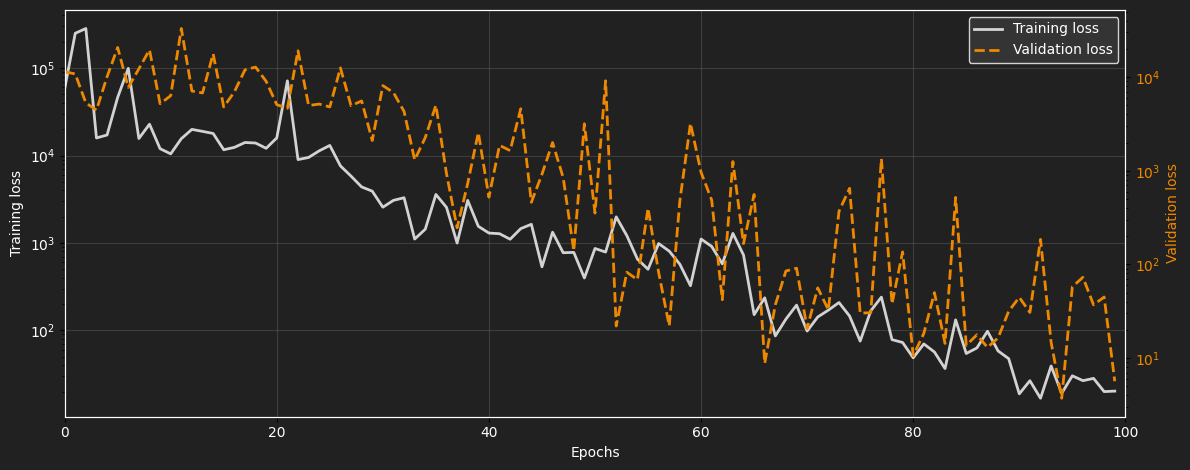

In [5]:
## Plot Losses
import matplotlib.pyplot as plt
import numpy as np

loss_np = np.array(losses[1:])
#loss_np = pd.read_csv('training_loss_2.csv').to_numpy()

plt, ax1 = plt.subplots()
plt.set_figwidth(12)
plt.patch.set_facecolor('#212121')
ax1.set_facecolor('#212121')  
ax1.grid(alpha=0.2)
x = np.arange(0,loss_np.shape[0])
ax1.plot(x, loss_np[:,0], label='Training loss', linewidth=2,color='white',alpha=0.8)
ax1.set_xlabel('Epochs',color='white')
#ax1.set_ylim(8000,15000)
ax1.set_ylabel('Training loss', color='white')
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelcolor='white')
ax1.tick_params(axis='y', labelcolor='white')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, loss_np[:,1], color='#ee8800', label='Validation loss', linewidth=2, linestyle='--')
#ax2.set_ylim(2000,5000)
ax2.set_yscale('log')
ax2.set_ylabel('Validation loss', color='#ee8800')
ax2.tick_params(axis='y', labelcolor='#ee8800')

for spine in ax1.spines.values():
    spine.set_color('white')
for spine in ax2.spines.values():
    spine.set_color('white')


ax1.set_xlim(0,100)
# Optional: combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', facecolor='#3a3a3a', edgecolor='white', labelcolor='white')
plt.tight_layout()
plt.show()

In [2]:
## Validation Cases
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import glob
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# Material encoding (1-h)
def load_material_vocab() -> Tuple[Dict[str, int], Dict[int, str]]:
    # CSV: idx,label
    #df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    #labels = sorted(df["label"].astype(str).unique().tolist())
    labels = ['concrete','steel','aluminum','CFRP'] #0,1,2,3 fixed material labels for now
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    return vocab

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def incidence_edges_from_conn(conn: np.ndarray, nodes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    Nc, Nv = conn.shape
    c_idx = np.repeat(np.arange(Nc, dtype=np.int64), Nv)
    n_idx = conn.reshape(-1)
    edge_index = torch.from_numpy(np.vstack([c_idx, n_idx])).long()
    node_tensor = nodes.to(edge_index.device)
    conn_tensor = torch.from_numpy(conn).long().to(edge_index.device)
    #edge attribute -> mesh to element centroid in xyz
    elem_nodes = node_tensor[conn_tensor]
    centroids = elem_nodes.mean(dim=1, keepdim=True)
    rel_disp = (elem_nodes - centroids).reshape(-1, elem_nodes.size(-1))

    return edge_index, rel_disp



# Connectivity
# mesh nodes <-> mesh nodes
# mesh nodes <-> element nodes

def data_to_graph(path:str,device):
    data = HeteroData()
    vocab = load_material_vocab()
    simdata = torch.load(path,weights_only=False)
    conn = simdata["elements"]
    conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
    nodes = simdata['nodes']
    label = simdata['material']
    c2n_ei, c2n_w = incidence_edges_from_conn(conn,nodes)  # [2, E_cn], [E_cn, 1]
    
    # mesh node properties: positions, internal forces, BC, dirichlet displacement
    data['nodes'].pos = nodes #                                             [N,3]
    data['nodes'].f_ext = simdata['ext_forces'] #external forces            [T,N,3]
    data['nodes'].bc = simdata['boundary'] #                                [N,3]
    #data['nodes'].dr = simdata['dirichlet_disp'] #dirichlet displacement   [N,3]

    # element node properties: material, stiffness matrix
    data['elements'].material = one_hot(label, vocab, device=device).unsqueeze(0).repeat(int(conn.shape[0]), 1) # [E,len(materials)]
    #data['elements'].stiffness = #stiffness is a learned feature

    # target properties
    # mesh: displacement over time
    # element: stress, damage state, internal forces
    data['nodes'].u_ts = simdata['u_history'] #                                     [T,N,3]
    data['elements'].s_ts = simdata['stress_history'] #                             [T,E,3]
    data['elements'].d_ts = simdata['state']
    data['nodes'].f_int = simdata['forces'] #internal forces in timeseries format     [T,N,3]

    # edges: connectivity mesh-mesh, mesh-element
    # mesh-element: distance to element centroid
    data["elements", "contributes", "nodes"].edge_index = c2n_ei
    data["elements", "contributes", "nodes"].edge_attr = c2n_w
    data["nodes", "belongs_to", "elements"].edge_index = c2n_ei.flip(0)
    data["nodes", "belongs_to", "elements"].edge_attr = c2n_w.flip(0)
    data['elements'].num_nodes = simdata['stress_history'].size(1)

    # mesh-mesh: distance
    ei = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1))
    data["nodes", "adjacent", "nodes"].edge_index = ei
    data["nodes", "adjacent_rev", "nodes"].edge_index = ei.flip(0)
    data["nodes", "adjacent", "nodes"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()

    #data['elements'].edge_index = simdata['elements'] #mesh-element [E,8]
    #data['nodes'].edge_index = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1)) #from stiffness matrix, only connectivity

    # for debugging dimensions
    #print(data['nodes'].num_nodes)                              # N
    #print(data['elements'].num_nodes)                           # E
    #print(data.num_edges)                                       # 2*((E*num_vertices)+())
    #print(data['nodes','adjacent','nodes'].num_edges)           # 
    #print(data['nodes','adjacent_rev','nodes'].num_edges)       #
    #print(data['elements','contributes','nodes'].num_edges)     # E*num_vertices
    #print(data['nodes','belongs_to','elements'].num_edges)      # E*num_vertices

    #data = data.pin_memory()
    data = data.to(device)
    return data

#data_to_graph('../torchfem_dataset/panel_plasticity_2/simulation_dump_3.pt',device)

device = torch.device('cpu')
data_dir = '../torchfem_dataset/panel_plasticity_2/'
files = (Path(data_dir).glob("simulation_dump_15*.pt"))
samples = []
for file in files:
    if '150' in str(file):
        continue
    data = data_to_graph(file,device)
    samples.append(data)
    print(file)
#print(len(files))


..\torchfem_dataset\panel_plasticity_2\simulation_dump_151.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_152.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_153.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_154.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_155.pt


In [91]:
torch.save(samples, "../base/test_dataset/test_combined.pt")

In [55]:
## Predictions from trained model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader

device = torch.device('cpu')
#samples = torch.load("../base/test_dataset/test_combined.pt",weights_only=False)
samples = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined_3.pt",weights_only=False)

def build_laststep_features(data, dtype=torch.float32):
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    #pos   = data['nodes'].pos.to(dtype)
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes → u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_ts, data['elements'].s_ts, data['elements'].d_ts, data['elements'].material
    #print(data.keys)

    return data

samples_dataset = [build_laststep_features(d) for d in samples]

## HGT Model
class HGTMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':    Linear(in_dims['nodes'], hidden),
            'elements': Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.head_u    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → u
        self.head_fint = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → f_int
        self.head_s    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 9))   # elements → s (3x3)
        #self.head_d    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 1))   # elements → d (optional)

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in self.lin_in.keys()}
        x = self.conv1(x, edge_index_dict); x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)

        h_nodes    = x['nodes']
        h_elements = x['elements']

        pred_u    = self.head_u(h_nodes)
        pred_fint = self.head_fint(h_nodes)
        pred_s    = self.head_s(h_elements)
        #pred_d    = self.head_d(h_elements)  # you can ignore this if d is missing

        return {'u': pred_u, 'fint': pred_fint, 's': pred_s}#, 'd': pred_d}
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# infer metadata and input dims from the first sample
metadata = samples_dataset[0].metadata()
in_dims = {
    'nodes':    samples_dataset[0]['nodes'].x.size(-1),
    'elements': samples_dataset[0]['elements'].x.size(-1),
}

model = HGTMultipleOutput(metadata, in_dims, hidden=64, heads=2).to(device)
model_state = torch.load('hgt_multitask_best_1411.pt')
model.load_state_dict(model_state)
model.eval()

sample_loader   = DataLoader(samples_dataset,   batch_size=1, shuffle=True)
sample = next(iter(sample_loader))
batch = sample.to(device)
#print(batch['nodes'].keys())
pred = model(batch.x_dict, batch.edge_index_dict)

In [56]:
from copy import deepcopy

out_samples = []
with torch.no_grad():
    for i, data in enumerate(samples_dataset):
        d = deepcopy(data)         # keep originals intact
        d = d.to(device)

        pred = model(d.x_dict, d.edge_index_dict)  # returns dict: {'u','fint','s'}

        # Detach and move predictions to CPU for saving
        pu = pred['u'].detach().cpu()
        pf = pred['fint'].detach().cpu()
        ps = pred['s'].detach().cpu()

        # Move the data structure back to CPU before attaching CPU tensors
        d = d.to('cpu')

        # Attach predictions into the dictionary
        d['nodes'].pred_u = pu
        d['nodes'].pred_fint = pf
        d['elements'].pred_s = ps

        out_samples.append(d)

# Save to a new file
save_path = "../base/test_dataset/test_combined_with_preds_1114.pt"
torch.save(out_samples, save_path)
print(f"Saved {len(out_samples)} samples with predictions to {save_path}")

Saved 118 samples with predictions to ../base/test_dataset/test_combined_with_preds_1114.pt


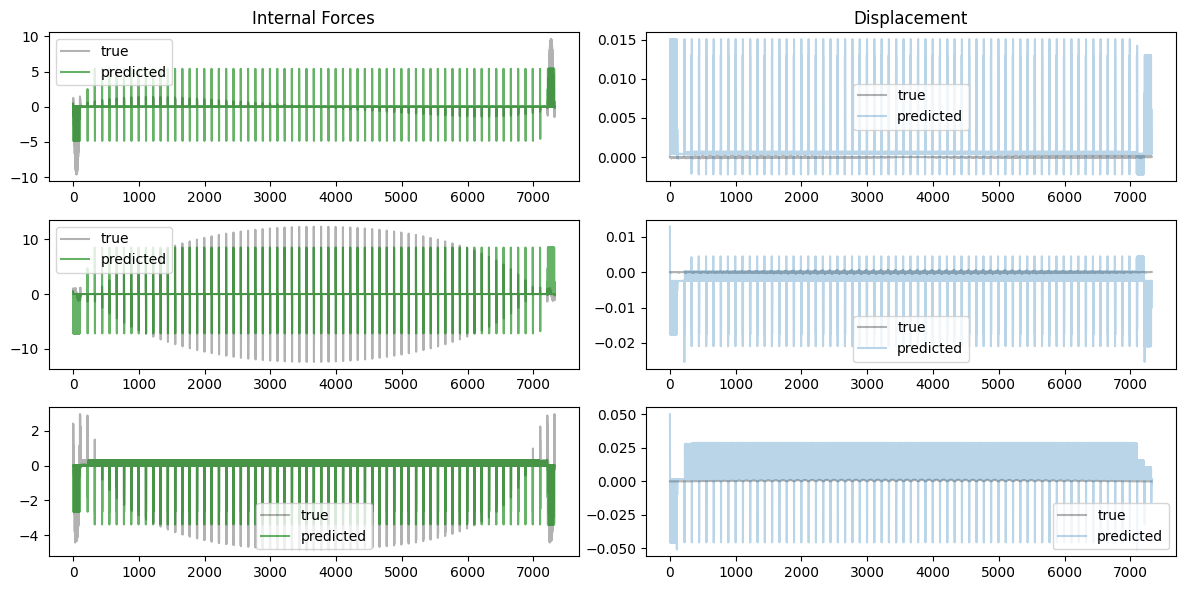

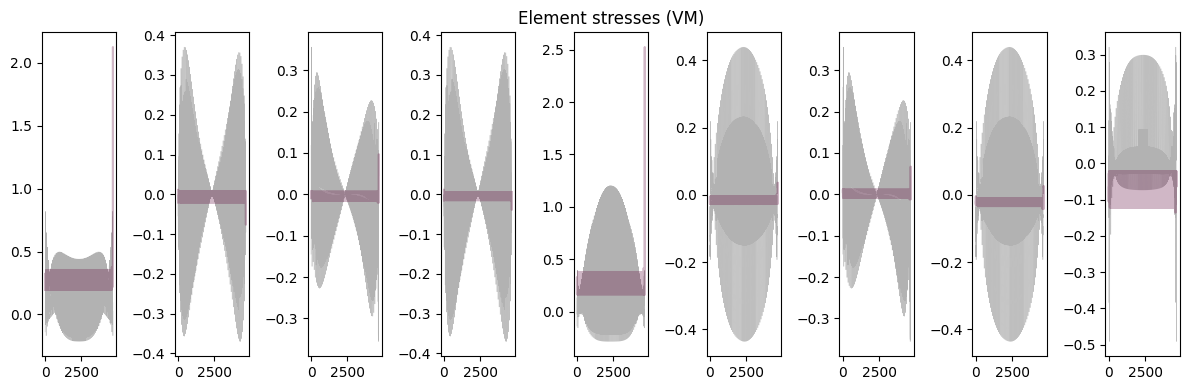

In [59]:
import matplotlib.pyplot as plt
out_samples = torch.load("../base/test_dataset/test_combined_with_preds_1114.pt",weights_only=False)

fig, ax = plt.subplots(3,2)
fig.set_figwidth(12)
fig.set_figheight(6)
sample = 14

ax[0,0].set_title('Internal Forces')
ax[0,1].set_title('Displacement')

for i in range(3):
    ax[i,1].plot(out_samples[sample]['nodes']['y_u'][:,i],'k',alpha=0.3,label='true')
    ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:,i],alpha=0.3,label='predicted')
    ax[i,1].legend()
    
    ax[i,0].plot(out_samples[sample]['nodes']['y_fint'][:,i],'k',alpha=0.3,label='true')
    ax[i,0].plot(out_samples[sample]['nodes']['pred_fint'][:,i],color='green',alpha=0.6,label='predicted')
    ax[i,0].legend()
plt.tight_layout()


fig, ax = plt.subplots(1,9)
fig.set_figwidth(12)
fig.set_figheight(4)
ax[4].set_title('Element stresses (VM)')
for i in range(9):
    ax[i].plot(out_samples[sample]['elements']['y_s'][:,i],'k',linewidth=0.3,alpha=0.3)
    ax[i].plot(out_samples[sample]['elements']['pred_s'][:,i],color='#661144',alpha=0.3)
plt.tight_layout()


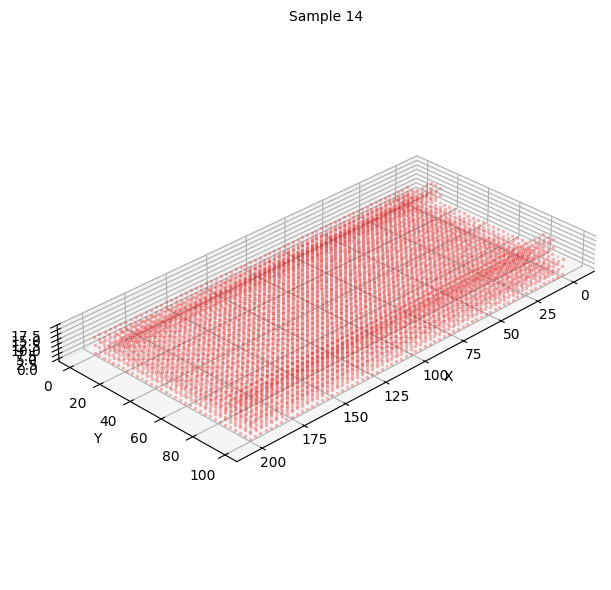

In [78]:
## Visualization - Matplotlib 3D Scatter Plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title(f'Sample {sample}',fontsize=10)

#sc = ax.scatter(out_samples[sample]['nodes']['pos'],'k',alpha=0.3,label='initial position')
#ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:],alpha=0.3,label='predicted')

#ax.plot_trisurf(V[:,0],V[:,1],V[:,2],triangles=F,edgecolor='#888888',linewidth=lw,antialiased=True,color='#dddddd',alpha=0.1)

vis_scale = 5

pos_init = out_samples[sample]['nodes']['pos']
pos_true = pos_init+out_samples[sample]['nodes']['y_u']*vis_scale
pos_pred = pos_init+out_samples[sample]['nodes']['pred_u']*vis_scale

#sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=2,marker='s',c='#1111dd',alpha=0.2,depthshade=True)
#sc2 = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=2,marker='s',c='#11dd11',alpha=0.1,depthshade=True)
sc3 = ax.scatter(pos_pred[:,0],pos_pred[:,1],pos_pred[:,2],s=2,marker='s',c='#dd1111',alpha=0.2,depthshade=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=30, azim=45)
ranges = np.ptp(out_samples[sample]['nodes']['pos'].T, axis=1)
ax.set_box_aspect(ranges)

plt.tight_layout()

In [70]:
from collections import Counter
import pyvista as pv
from collections import defaultdict
import numpy as np

vis_scale = 5000

pos = out_samples[sample]['nodes']['pos'].cpu().numpy()        # (N,3)
edges = out_samples[sample][('nodes','adjacent','nodes')]['edge_index'].T.cpu().numpy()
pos_true = pos+(out_samples[sample]['nodes']['y_u']*vis_scale).cpu().numpy()
pos_pred = pos+(out_samples[sample]['nodes']['pred_u']*vis_scale).cpu().numpy()

adj = defaultdict(set)
for i, j in edges:
    adj[i].add(j)
    adj[j].add(i)

def find_quad_faces(adj):
    faces = set()

    for a in adj:
        for b in adj[a]:
            for c in adj[b]:
                if c == a: continue
                for d in adj[c]:
                    if d in adj[a] and d not in (a,b,c):    # closes the loop
                        quad = tuple(sorted([a,b,c,d]))
                        faces.add(quad)

    return np.array(list(faces))

faces = find_quad_faces(adj)

# Count duplicates
face_counts = Counter([tuple(sorted(f)) for f in faces])

surface_faces = np.array([f for f, c in face_counts.items() if c == 1])


# Convert to VTK-style quad faces
faces_pv = np.hstack([
    np.concatenate([[4], face]) for face in surface_faces
])

mesh = pv.PolyData(pos_true, faces_pv)

mesh.plot(
    show_edges=False,
    color="#8fa7ff",
    smooth_shading=False,
    opacity=0.95,
)


Widget(value='<iframe src="http://localhost:54958/index.html?ui=P_0x2ae44db53d0_14&reconnect=auto" class="pyvi…

6529.688736637018 -3.185553210105496e-11 -7.36733590800398e-11 6.379291539460041e-11
-3.185553210105496e-11 -7.36733590800398e-11 6529.688736637081
0.0 0.0 6529.688736637017


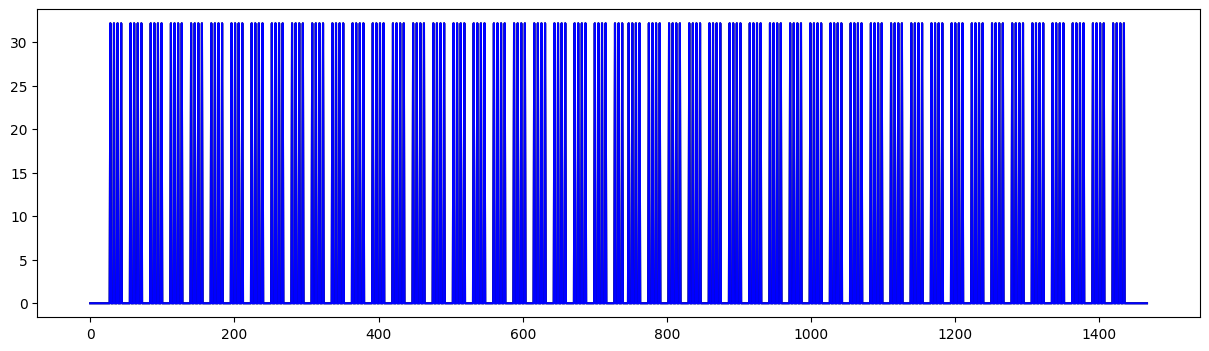

In [192]:
import torch
import numpy as np
import matplotlib.pyplot as plt

sim = torch.load('../base/euler_dataset/panel_plasticity_2/simulation_dump_4.pt')
fint = sim['forces'].detach().cpu().numpy()
fext = sim['ext_forces']
t = 15

mask = sim['boundary']

fint = fint[:,~mask[:,0]]
fext = fext[:,~mask[:,0]]
ext_t = fext[t].sum()
x_eq = (fint[t,:,0]-fext[t,:,0]).sum()
y_eq = (fint[t,:,1]-fext[t,:,1]).sum()
z_eq = (fint[t,:,2]-fext[t,:,2]).sum()
print(ext_t,x_eq,y_eq,z_eq)
print(fint[t,:,0].sum(),fint[t,:,1].sum(),fint[t,:,2].sum())
print(fext[t,:,0].sum(),fext[t,:,1].sum(),fext[t,:,2].sum())

residual = fint[t]+fext[t]

#print(sim['stiffness'].shape,sim['nodes'].shape,sim['elements'].shape)
#print(sim['elements'][0])
#print(sim['nodes'][sim['elements'][0]])
V = sim['nodes']
F = sim['elements']
plt.figure(figsize=(15,4))
#plt.xlim(0,200)
plt.plot(fint[t,:,2],'k')
plt.plot(fext[t,:,2],'b')

#F = torch.column_stack([F,F[:,0]])
#F_edges = np.unique(np.sort(torch.vstack([F[:,i:i+2] for i in range(8)]),axis=1),axis=0)

def mesh_edges_from_conn(conn: torch.Tensor) -> torch.Tensor:
    conn = conn.long()                             # [E, nverts]
    hex_edges = torch.tensor([
        [0,1], [1,2], [2,3], [3,0],     # bottom face
        [4,5], [5,6], [6,7], [7,4],     # top face
        [0,4], [1,5], [2,6], [3,7],     # vertical edges
    ])
    pairs = conn[:, hex_edges]          # [E, 12, 2]
    pairs = pairs.reshape(-1, 2)
    pairs = torch.unique(torch.sort(pairs, dim=1).values, dim=0)
    edge_index = torch.cat([pairs, pairs.flip(1)], dim=0).T
    #edge_index = pairs.T
    return edge_index

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

#F_edges = stiffness_to_node_adj_edge_index(K=sim['stiffness'],num_nodes=0,dof_per_node=3)
#F_edges = mesh_edges_from_conn(F)
#count = (F_edges==127).sum()
# per element: 12 edges, 8 nodes
# per node: 3 -> 6 connections
